### Table of Contents

### 00. Load Data
##### Data Selection

In [1]:
import random
import numpy as np
# for reproducibility
random.seed(123)
np.random.seed(123)

In [2]:
def get_random_list(num_items, start, end, set_seed=123):
    random.seed(set_seed)
    selected_idx = [i for i in range(start,end)]
    random.shuffle(selected_idx)
    return sorted(selected_idx[0:num_items])

def train_test_split(input_list, train_proportion=0.7, set_seed=123):
    train_idx = get_random_list(num_items=round(len(input_list)*train_proportion), 
                                start=0, end=len(input_list), set_seed=123)
    train_list = []
    test_list = []
    for i in range(0,len(input_list)):
        if i in train_idx:
            train_list.append(input_list[i])
        else:
            test_list.append(input_list[i])
    return train_list, test_list

In [3]:
# choose 25 PIE subjects
selected_idx = get_random_list(num_items=25, start=1, end=68, set_seed=123)
print('Selected subjects:', selected_idx)

Selected subjects: [2, 8, 13, 14, 15, 17, 19, 20, 23, 24, 27, 31, 32, 33, 34, 40, 42, 44, 46, 48, 50, 52, 59, 63, 65]


In [4]:
NUM_IMG_PER_SUBJ = 170
NUM_SELFIES = 10

# list of paths to PIE images
pie_list = []
for subj_idx in selected_idx:
    temp_list = ['PIE//'+str(subj_idx)+'//'+str(i+1)+'.jpg' for i in range(0,NUM_IMG_PER_SUBJ)]
    pie_list.extend(temp_list)

# list of paths to selfies
selfies_list = ['selfies//formatted//'+str(i+1)+'.jpg' for i in range(0,NUM_SELFIES)]

# list of paths to all images of interest
list_of_img_end_paths = pie_list + selfies_list

print('Number of selected PIE images:', len(pie_list))
print('Number of selected selfies:', len(selfies_list))
print('Number of selected images:', len(list_of_img_end_paths))

Number of selected PIE images: 4250
Number of selected selfies: 10
Number of selected images: 4260


##### Train Test Split

In [5]:
TRAIN_PROPORTION = 0.7

# split PIE train and test
pie_train_list, pie_test_list = train_test_split(pie_list, train_proportion=TRAIN_PROPORTION, set_seed=123)

# split selfies train and test
selfies_train_list, selfies_test_list = train_test_split(selfies_list, train_proportion=TRAIN_PROPORTION, set_seed=123)

print('Number||Proportion of train PIE images:', len(pie_train_list), '||', len(pie_train_list)/len(pie_list))
print('Number||Proportion of test PIE images:', len(pie_test_list), '||', len(pie_test_list)/len(pie_list))
print('Number||Proportion of train selfies:', len(selfies_train_list), '||', len(selfies_train_list)/len(selfies_list))
print('Number||Proportion of test selfies:', len(selfies_test_list), '||', len(selfies_test_list)/len(selfies_list))

Number||Proportion of train PIE images: 2975 || 0.7
Number||Proportion of test PIE images: 1275 || 0.3
Number||Proportion of train selfies: 7 || 0.7
Number||Proportion of test selfies: 3 || 0.3


### 01. Principal Component Analysis (PCA)

In [6]:
import numpy as np
import cv2
import os
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [7]:
# Randomly sample 500 images from the CMU PIE training set and add train selfies
NUM_RANDS = 500

random_idx = get_random_list(num_items=NUM_RANDS, start=0, end=len(pie_train_list), set_seed=123)
random_img_end_paths = [pie_train_list[i] for i in random_idx]
random_img_end_paths.extend(selfies_train_list)

In [8]:
def get_labels_from_path_list(list_of_img_paths, label_type='general'):
    label_list = []
    for path in list_of_img_paths:
        splitted = path.split('//')
        if splitted[0]=='PIE':
            if label_type=='general':
                label_list.append(splitted[0])
            elif label_type=='specific':
                label_list.append(splitted[1])
            else:
                print("Please specify label_type as 'general' or 'specific'")
        else:
            if label_type=='general':
                label_list.append(splitted[0])
            elif label_type=='specific':
                label_list.append('selfies')
            else:
                print("Please specify label_type as 'general' or 'specific'")
    return label_list

train_general_labels = get_labels_from_path_list(random_img_end_paths, label_type='general')
train_specific_labels = get_labels_from_path_list(random_img_end_paths, label_type='specific')

In [9]:
def load_and_vectorise_images(list_of_img_paths):
    # read image
    path = os.path.abspath('')

    for counter, end_paths in enumerate(list_of_img_paths):
        # load image
        img = cv2.imread(os.path.join(path, end_paths))

        # vectorise image
        array_size = img.shape[0]*img.shape[1]
        vectorised_img = img.copy()
        vectorised_img = vectorised_img.reshape(array_size,3)
        vectorised_img = np.array([i[0] for i in vectorised_img], dtype=int)

        # add to dataset
        if counter == 0:
            data = vectorised_img.reshape(1,array_size).copy()
        else:
            data = np.concatenate((data, vectorised_img.reshape(1,array_size)), axis=0)
    return data

data = load_and_vectorise_images(random_img_end_paths)
print('Vectorised and loaded data:', data.shape)

Vectorised and loaded data: (507, 1024)


##### 2D & 3D PCA + Plots

In [10]:
def plot_2d_or_3d(x_data, y_data, title_name='Projected Components', save_name='plot.png', x_label='X', y_label='Y', z_label='Z', pal=None):
    # format labels and colours
    y_set = list(set(y_data))
    if pal is None:
        if len(y_set)==2:
            #label_to_colour={'PIE':'lightblue', 'selfies':'orange'}
            pal=['lightblue','orange']
        else:
            colour_list=list(mcolors.CSS4_COLORS.keys())
            label_to_colour = {y_set[i]: colour_list[i] for i in range(0, len(y_set))}
            pal=[label_to_colour[label] for label in y_set]
        
    # plot 2d or 3d
    if x_data.shape[1]==2: # if 2D
        sns.relplot(x=x_data[:, 0], y=x_data[:, 1], hue=y_data, palette=pal)
        plt.title(title_name)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.savefig(save_name)
        plt.show()
    elif x_data.shape[1]==3: # if 3D
        y_data = np.array(y_data)
        fig = plt.figure()
        ax = Axes3D(fig)
        for i, label in enumerate(y_set):
            ax.scatter(x_data[y_data == label, 0], x_data[y_data == label, 1], x_data[y_data == label, 2], c=pal[i], label=label)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_zlabel(z_label)
        plt.title(title_name)
        plt.legend()
        plt.savefig(save_name)
        plt.show()
    else:
        print('Error: Number of columns in data is not 2 or 3!')

2-PCs explained variance ratio: [0.41569115 0.26346372]
2-PCs singular values: [24469.93859362 19480.84976226]


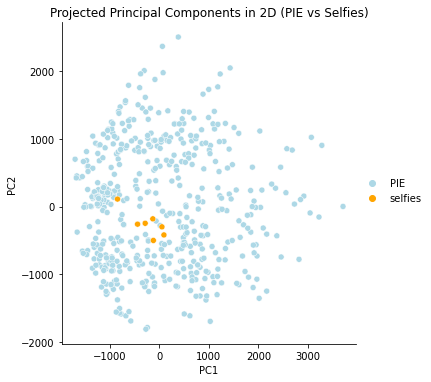

In [11]:
# reduce dimensionality of vectorized images to 2
n_pc = 2
pca = PCA(n_components=n_pc)
pca.fit(np.asmatrix(data))

print('{}-PCs explained variance ratio: {}'.format(n_pc, pca.explained_variance_ratio_))
print('{}-PCs singular values: {}'.format(n_pc, pca.singular_values_))

# project data into 2d
x_pca_2d = pca.transform(np.asmatrix(data))

# visualise projected data vector in 2d plot
plot_2d_or_3d(x_pca_2d, train_general_labels, title_name='Projected Principal Components in 2D (PIE vs Selfies)', 
              save_name='PCA_2D.png', x_label='PC1', y_label='PC2')

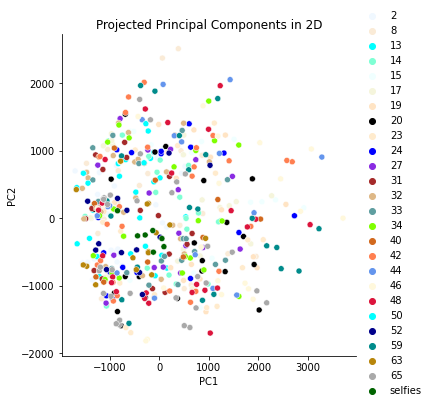

In [12]:
# visualise projected data vector in 2d plot
plot_2d_or_3d(x_pca_2d, train_specific_labels, title_name='Projected Principal Components in 2D', 
              save_name='PCA_2D_specific.png', x_label='PC1', y_label='PC2')

3-PCs explained variance ratio: [0.41569115 0.26346372 0.0731774 ]
3-PCs singular values: [24469.93859362 19480.84976226 10266.82062166]


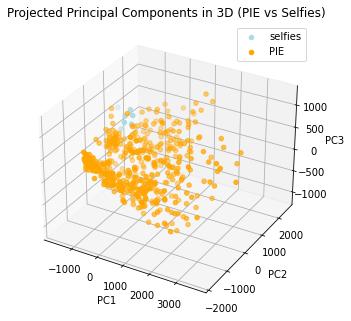

In [13]:
# reduce dimensionality of vectorized images to 3
n_pc = 3
pca = PCA(n_components=n_pc)
pca.fit(np.asmatrix(data))

print('{}-PCs explained variance ratio: {}'.format(n_pc, pca.explained_variance_ratio_))
print('{}-PCs singular values: {}'.format(n_pc, pca.singular_values_))

# project data into 3d
x_pca_3d = pca.transform(np.asmatrix(data))

# visualise projected data vector in 3d plot
plot_2d_or_3d(x_pca_3d, train_general_labels, title_name='Projected Principal Components in 3D (PIE vs Selfies)', 
              save_name='PCA_3D.png', x_label='PC1', y_label='PC2', z_label='PC3')

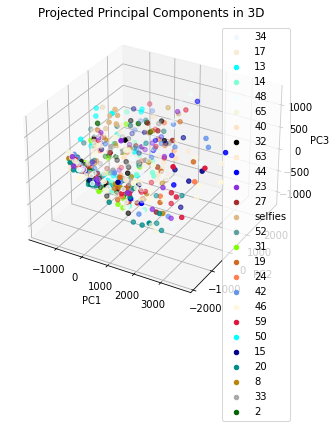

In [14]:
# visualise projected data vector in 3d plot
plot_2d_or_3d(x_pca_3d, train_specific_labels, title_name='Projected Principal Components in 3D', 
              save_name='PCA_3D_specific.png', x_label='PC1', y_label='PC2', z_label='PC3')

##### Eigenfaces
Visualise the 3 eigenfaces used for dimensionality reduction

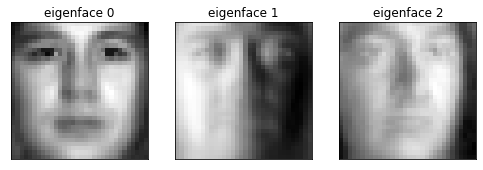

In [15]:
# adapted from https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
        
n_pc = 3
h = 32
w = 32

n_samples, n_features = data.shape
mean = np.mean(data, axis=0)
centered_data = data-mean
U, S, V = np.linalg.svd(centered_data)
components = V[:n_pc]
projected = U[:,:n_pc]*S[:n_pc]

eigenfaces = components.reshape((3, h, w))
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]

if n_pc<4:
    cols=n_pc
    rows=1
else:
    cols=4
    rows=math.ceil(n_pc/cols)
    
plot_portraits(eigenfaces, eigenface_titles, h, w, rows, cols)

##### PCA Classification
Apply PCA to reduce the dimensionality of face images to 40, 80 and 200 respectively. Here we use the full train dataset. Classifying the test images using the rule of nearest neighbor. Report the classification accuracy on the CMU PIE test images and your own photo seperately.

In [16]:
# load test data
train_data = load_and_vectorise_images(pie_train_list+selfies_train_list)
test_data = load_and_vectorise_images(pie_test_list+selfies_test_list)
print('Vectorised and loaded train data:', train_data.shape)
print('Vectorised and loaded test data:', test_data.shape)

Vectorised and loaded train data: (2982, 1024)
Vectorised and loaded test data: (1278, 1024)


In [17]:
# prepare specific labels (target var for classification task)
train_labels = get_labels_from_path_list(pie_train_list+selfies_train_list, label_type='specific')
test_labels = get_labels_from_path_list(pie_test_list+selfies_test_list, label_type='specific')

In [18]:
def calculate_accuracy(predicted_list, actual_list):
    return sum([1 for pred, actual in zip(predicted_list, actual_list) if pred==actual])/len(predicted_list)
    
def perform_clf_plus_knn(classifier, train_data, train_labels, test_data, test_labels, clf_name='Classifier', n_pc=3, k=1,cut_off=None):
    # reduce dimensionality of vectorized images to n_pc
    clf = classifier(n_components=n_pc)
    if clf_name=='LDA':
        clf.fit(np.asmatrix(train_data), train_labels)
    else:
        clf.fit(np.asmatrix(train_data))

    # project train and test data into n_pc-d
    train_x_clf_nd = clf.transform(np.asmatrix(train_data))
    test_x_clf_nd = clf.transform(np.asmatrix(test_data))

    # the 1-NN model
    knn = KNeighborsClassifier(k)
    knn.fit(train_x_clf_nd, train_labels)
    test_pred = knn.predict(test_x_clf_nd)

    # calculate accuracy
    print('Accuracy of {}-NN with {}-components {} for ALL test set: {}%'.format(
        k, n_pc, clf_name, round(calculate_accuracy(test_pred, test_labels)*100,3)))
    
    if cut_off is not None:
        print('Accuracy of {}-NN with {}-components {} for PIE test set: {}%'.format(
            k, n_pc, clf_name, round(calculate_accuracy(test_pred[0:cut_off-1], test_labels[0:cut_off-1])*100,3)))
        print('Accuracy of {}-NN with {}-components {} for selfies test set: {}%'.format(
            k, n_pc, clf_name, round(calculate_accuracy(test_pred[cut_off:], test_labels[cut_off:])*100,3)))
    
    #return test_pred

In [19]:
perform_clf_plus_knn(PCA, train_data, train_labels, test_data, test_labels, clf_name='PCA', n_pc=40, k=1, cut_off=len(pie_test_list))
perform_clf_plus_knn(PCA, train_data, train_labels, test_data, test_labels, clf_name='PCA', n_pc=80, k=1, cut_off=len(pie_test_list))
perform_clf_plus_knn(PCA, train_data, train_labels, test_data, test_labels, clf_name='PCA', n_pc=200, k=1, cut_off=len(pie_test_list))

Accuracy of 1-NN with 40-components PCA for ALL test set: 93.114%
Accuracy of 1-NN with 40-components PCA for PIE test set: 93.171%
Accuracy of 1-NN with 40-components PCA for selfies test set: 66.667%
Accuracy of 1-NN with 80-components PCA for ALL test set: 95.149%
Accuracy of 1-NN with 80-components PCA for PIE test set: 95.212%
Accuracy of 1-NN with 80-components PCA for selfies test set: 66.667%
Accuracy of 1-NN with 200-components PCA for ALL test set: 96.009%
Accuracy of 1-NN with 200-components PCA for PIE test set: 96.075%
Accuracy of 1-NN with 200-components PCA for selfies test set: 66.667%


### 02. Linear Discriminant Analysis (LDA)

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

##### 2D & 3D LDA Plots
Visualize distribution of the sampled data (as in the PCA section) with dimensionality of 2 and 3 respectively (similar to
PCA).

2-components LDA explained variance ratio: [0.14417813 0.09386147]


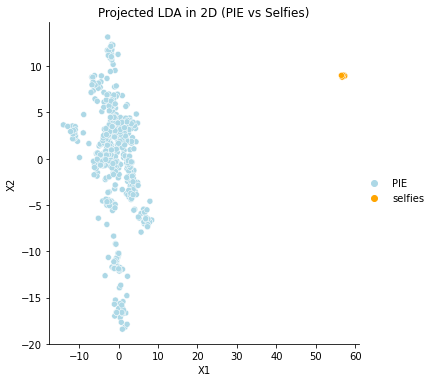

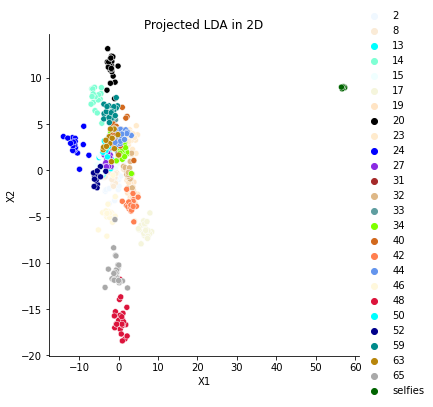

In [21]:
# reduce dimensionality of vectorized images to 2
n_pc = 2
lda = LinearDiscriminantAnalysis(n_components=n_pc)
lda.fit(np.asmatrix(data), train_specific_labels)

print('{}-components LDA explained variance ratio: {}'.format(n_pc, lda.explained_variance_ratio_))

# project data into 2d
x_lda_2d = lda.transform(np.asmatrix(data))

# visualise projected data vector in 2d plot
plot_2d_or_3d(x_lda_2d, train_general_labels, title_name='Projected LDA in 2D (PIE vs Selfies)', 
              save_name='LDA_2D.png', x_label='X1', y_label='X2')

plot_2d_or_3d(x_lda_2d, train_specific_labels, title_name='Projected LDA in 2D', 
              save_name='LDA_2D_specific.png', x_label='X1', y_label='X2')

3-components LDA explained variance ratio: [0.14417813 0.09386147 0.07444245]


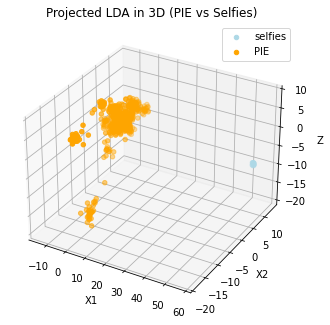

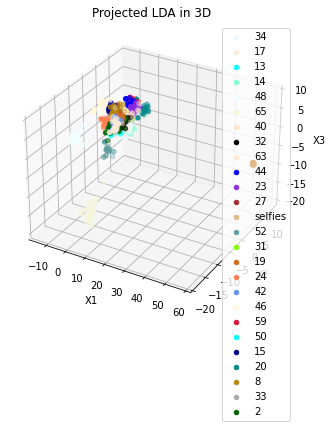

In [22]:
# reduce dimensionality of vectorized images to 3
n_pc = 3
lda = LinearDiscriminantAnalysis(n_components=n_pc)
lda.fit(np.asmatrix(data), train_specific_labels)

print('{}-components LDA explained variance ratio: {}'.format(n_pc, lda.explained_variance_ratio_))

# project data into 3d
x_lda_3d = lda.transform(np.asmatrix(data))

# visualise projected data vector in 3d plot
plot_2d_or_3d(x_lda_3d, np.array(train_general_labels), title_name='Projected LDA in 3D (PIE vs Selfies)', 
              save_name='LDA_3D.png', x_label='X1', y_label='X2')

plot_2d_or_3d(x_lda_3d, np.array(train_specific_labels), title_name='Projected LDA in 3D', 
              save_name='LDA_3D_specific.png', x_label='X1', y_label='X2', z_label='X3')

In [23]:
# reduce dimensionality of vectorized images to 9
n_pc = 9
lda = LinearDiscriminantAnalysis(n_components=n_pc)
lda.fit(np.asmatrix(data), train_specific_labels)

print('{}-components LDA explained variance ratio: {}'.format(n_pc, lda.explained_variance_ratio_))

9-components LDA explained variance ratio: [0.14417813 0.09386147 0.07444245 0.06792382 0.06342089 0.05451227
 0.05299245 0.04600756 0.04058535]


##### LDA Classification 
Apply LDA to reduce data dimensionality to 2, 3 and 9. Here we use the full train dataset.  Report the classification accuracy for data with dimensions of 2, 3 and 9 respectively,
based on nearest neighbor classifier. Report the classification accuracy on the CMU PIE test
images and your own photo seperately.

In [24]:
perform_clf_plus_knn(LinearDiscriminantAnalysis, train_data, train_labels, test_data, test_labels, clf_name='LDA', n_pc=2, k=1, cut_off=len(pie_test_list))
perform_clf_plus_knn(LinearDiscriminantAnalysis, train_data, train_labels, test_data, test_labels, clf_name='LDA', n_pc=3, k=1, cut_off=len(pie_test_list))
perform_clf_plus_knn(LinearDiscriminantAnalysis, train_data, train_labels, test_data, test_labels, clf_name='LDA', n_pc=9, k=1, cut_off=len(pie_test_list))

Accuracy of 1-NN with 2-components LDA for ALL test set: 23.944%
Accuracy of 1-NN with 2-components LDA for PIE test set: 23.94%
Accuracy of 1-NN with 2-components LDA for selfies test set: 0.0%
Accuracy of 1-NN with 3-components LDA for ALL test set: 41.706%
Accuracy of 1-NN with 3-components LDA for PIE test set: 41.758%
Accuracy of 1-NN with 3-components LDA for selfies test set: 0.0%
Accuracy of 1-NN with 9-components LDA for ALL test set: 90.219%
Accuracy of 1-NN with 9-components LDA for PIE test set: 90.424%
Accuracy of 1-NN with 9-components LDA for selfies test set: 0.0%


In [25]:
train_data.shape

(2982, 1024)

In [26]:
perform_clf_plus_knn(LinearDiscriminantAnalysis, data, train_specific_labels, test_data, test_labels, clf_name='LDA', n_pc=2, k=1, cut_off=len(pie_test_list))
perform_clf_plus_knn(LinearDiscriminantAnalysis, data, train_specific_labels, test_data, test_labels, clf_name='LDA', n_pc=3, k=1, cut_off=len(pie_test_list))
perform_clf_plus_knn(LinearDiscriminantAnalysis, data, train_specific_labels, test_data, test_labels, clf_name='LDA', n_pc=9, k=1, cut_off=len(pie_test_list))

Accuracy of 1-NN with 2-components LDA for ALL test set: 25.039%
Accuracy of 1-NN with 2-components LDA for PIE test set: 24.882%
Accuracy of 1-NN with 2-components LDA for selfies test set: 100.0%
Accuracy of 1-NN with 3-components LDA for ALL test set: 34.977%
Accuracy of 1-NN with 3-components LDA for PIE test set: 34.851%
Accuracy of 1-NN with 3-components LDA for selfies test set: 66.667%
Accuracy of 1-NN with 9-components LDA for ALL test set: 69.953%
Accuracy of 1-NN with 9-components LDA for PIE test set: 69.859%
Accuracy of 1-NN with 9-components LDA for selfies test set: 100.0%


### 03. Gaussian Mixture Model (GMM)
Use the raw face images (vectorized) and the face vectors after PCA pre-processing (with dimensionality
of 200 and 80 respectively) as the provided training data. Train a GMM model
with 3 Gaussian components on these data. Visualize the clustering results from GMM, i.e.,
visualize the images that are assigned to the same component.

In [27]:
from sklearn.mixture import GaussianMixture

##### Using raw face images

In [28]:
np.asmatrix(train_data).shape

(2982, 1024)

3-components GMM weights: [0.38095238 0.31052985 0.30851777]


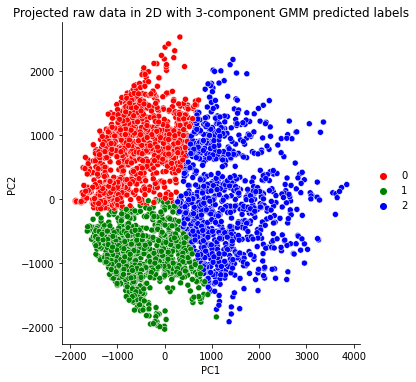

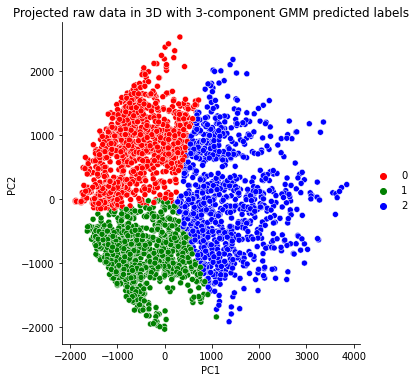

In [29]:
# reduce dimensionality of vectorized images to n_pc
n_pc = 2
pca = PCA(n_components=n_pc)
pca.fit(np.asmatrix(train_data))
# project data into nd | to plot
x_pca_nd = pca.transform(np.asmatrix(train_data))

# perform classification
gmm = GaussianMixture(n_components=3)
gmm.fit(np.asmatrix(train_data))
print('{}-components GMM weights: {}'.format(3, gmm.weights_))
gmm_pred_labels = gmm.predict(np.asmatrix(train_data))

# visualise first 2,3 PCs with GMM labels 
plot_2d_or_3d(x_pca_nd[:,:2], gmm_pred_labels, 
              title_name='Projected raw data in 2D with {}-component GMM predicted labels'.format(3), 
              save_name='RAW_2D_{}GMM.png'.format(3), 
              x_label='PC1', y_label='PC2', pal=['red','green','blue'])

plot_2d_or_3d(x_pca_nd[:,:3], gmm_pred_labels, 
              title_name='Projected raw data in 3D with {}-component GMM predicted labels'.format(3), 
              save_name='RAW_PCA_3D_{}GMM.png'.format(3), 
              x_label='PC1', y_label='PC2', z_label='PC3', pal=['red','green','blue'])

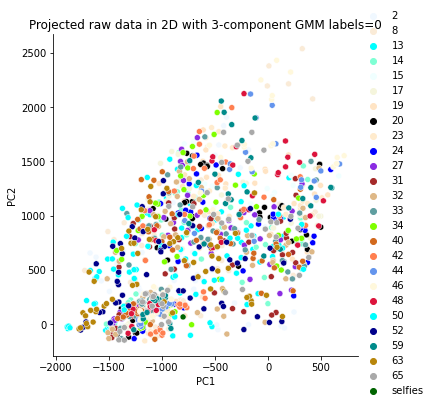

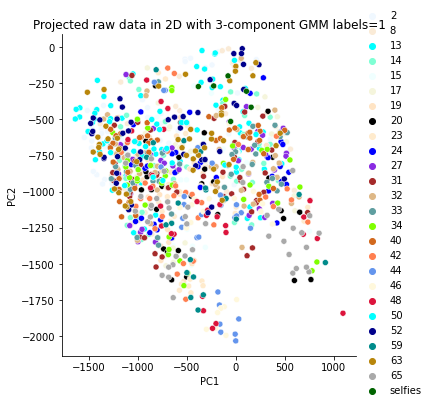

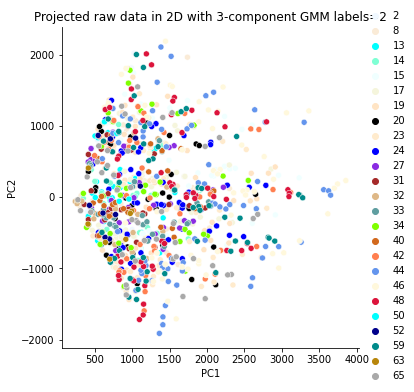

In [30]:
# visualize the images that are assigned to the same component
for label in range(0,3):
    _train_labels = [train_labels[i] for i in range(0, len(gmm_pred_labels)) if gmm_pred_labels[i]==label]
    plot_2d_or_3d(x_pca_nd[gmm_pred_labels==label,:2], _train_labels, 
                  title_name='Projected raw data in 2D with {}-component GMM labels={}'.format(3, label), 
                  save_name='RAW_2D_{}GMM_Y{}.png'.format(3, label), 
                  x_label='PC1', y_label='PC2')

##### Using PCA pre-processed images

3-components GMM weights: [0.34501616 0.31345351 0.34153033]


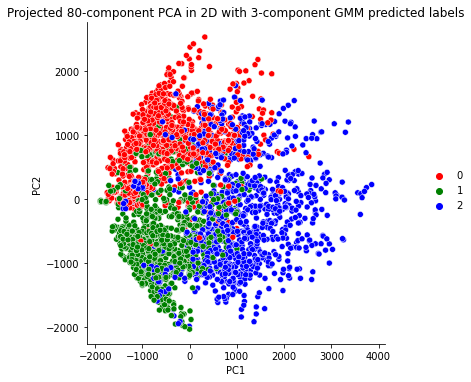

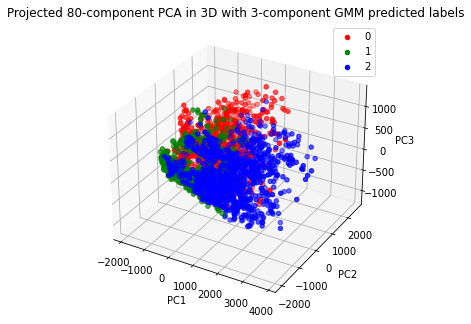

In [31]:
# reduce dimensionality of vectorized images to n_pc
n_pc = 80
pca = PCA(n_components=n_pc)
pca.fit(np.asmatrix(train_data))
# project data into nd
x_pca_nd = pca.transform(np.asmatrix(train_data))

# perform classification
gmm = GaussianMixture(n_components=3)
gmm.fit(np.asmatrix(x_pca_nd))
print('{}-components GMM weights: {}'.format(3, gmm.weights_))
gmm_pred_labels = gmm.predict(np.asmatrix(x_pca_nd))

# visualise first 2,3 PCs with GMM labels 
plot_2d_or_3d(x_pca_nd[:,:2], gmm_pred_labels, 
              title_name='Projected {}-component PCA in 2D with {}-component GMM predicted labels'.format(n_pc, 3), 
              save_name='{}C_PCA_2D_{}GMM.png'.format(n_pc, 3), 
              x_label='PC1', y_label='PC2', pal=['red','green','blue'])

plot_2d_or_3d(x_pca_nd[:,:3], gmm_pred_labels, 
              title_name='Projected {}-component PCA in 3D with {}-component GMM predicted labels'.format(n_pc, 3), 
              save_name='{}C_PCA_3D_{}GMM.png'.format(n_pc, 3), 
              x_label='PC1', y_label='PC2', z_label='PC3', pal=['red','green','blue'])

In [32]:
x_pca_nd.shape

(2982, 80)

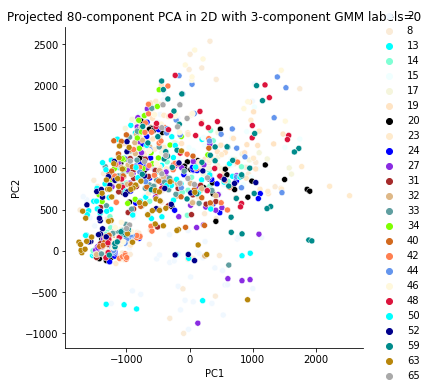

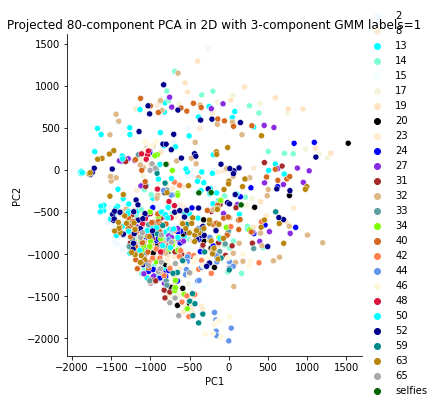

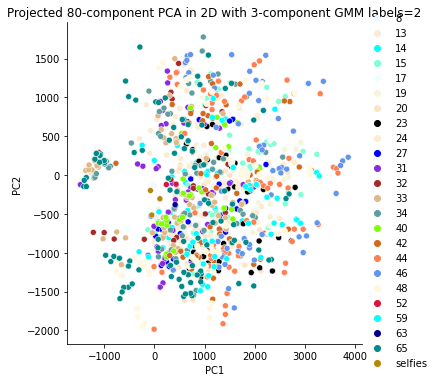

In [33]:
# visualize the images that are assigned to the same component
for label in range(0,3):
    _train_labels = [train_labels[i] for i in range(0, len(gmm_pred_labels)) if gmm_pred_labels[i]==label]
    plot_2d_or_3d(x_pca_nd[gmm_pred_labels==label,:2], _train_labels, 
                  title_name='Projected {}-component PCA in 2D with {}-component GMM labels={}'.format(n_pc, 3, label), 
                  save_name='{}C_PCA_2D_{}GMM_Y{}.png'.format(n_pc, 3, label), 
                  x_label='PC1', y_label='PC2')

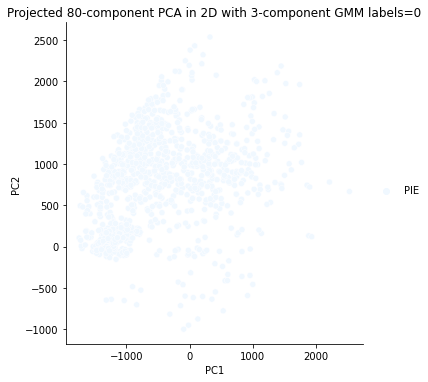

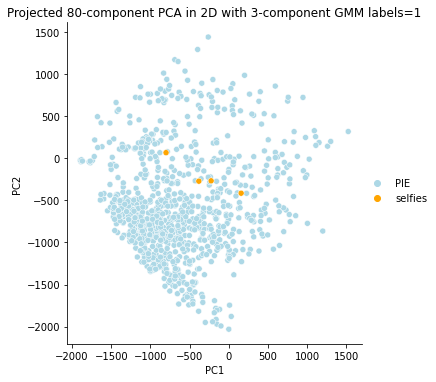

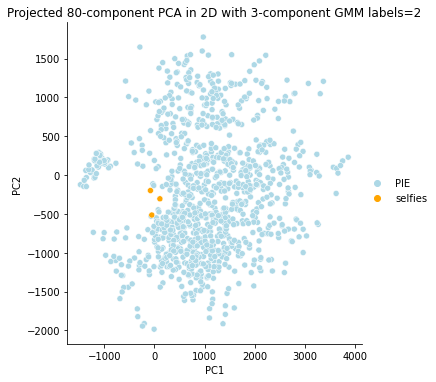

In [34]:
# visualize the images that are assigned to the same component
# use general labels
train_labels_gen = get_labels_from_path_list(pie_train_list+selfies_train_list, label_type='general')
for label in range(0,3):
    _train_labels = [train_labels_gen[i] for i in range(0, len(gmm_pred_labels)) if gmm_pred_labels[i]==label]
    plot_2d_or_3d(x_pca_nd[gmm_pred_labels==label,:2], _train_labels, 
                  title_name='Projected {}-component PCA in 2D with {}-component GMM labels={}'.format(n_pc, 3, label), 
                  save_name='{}C_PCA_2D_{}GMM_Y{}_gen.png'.format(n_pc, 3, label), 
                  x_label='PC1', y_label='PC2')

3-components GMM weights: [0.39609862 0.30164113 0.30226025]


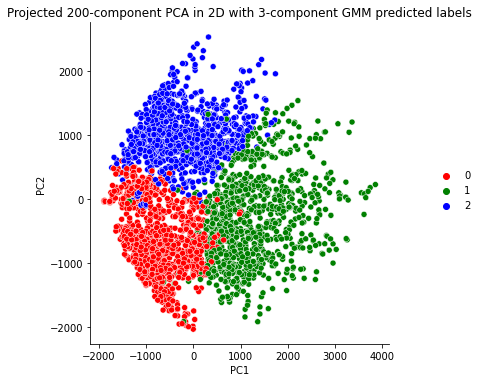

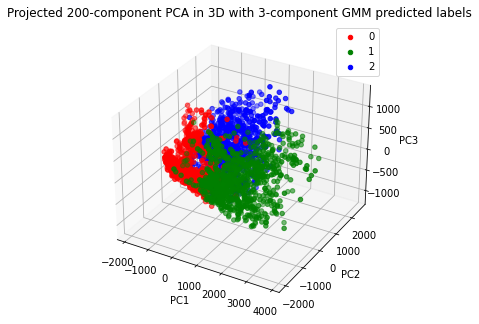

In [35]:
# reduce dimensionality of vectorized images to n_pc
n_pc = 200
pca = PCA(n_components=n_pc)
pca.fit(np.asmatrix(train_data))
# project data into nd
x_pca_nd = pca.transform(np.asmatrix(train_data))

# perform classification
gmm = GaussianMixture(n_components=3)
gmm.fit(np.asmatrix(x_pca_nd))
print('{}-components GMM weights: {}'.format(3, gmm.weights_))
gmm_pred_labels = gmm.predict(np.asmatrix(x_pca_nd))

# visualise first 2,3 PCs with GMM labels 
plot_2d_or_3d(x_pca_nd[:,:2], gmm_pred_labels, 
              title_name='Projected {}-component PCA in 2D with {}-component GMM predicted labels'.format(n_pc, 3), 
              save_name='{}C_PCA_2D_{}GMM.png'.format(n_pc, 3), 
              x_label='PC1', y_label='PC2', pal=['red','green','blue'])

plot_2d_or_3d(x_pca_nd[:,:3], gmm_pred_labels, 
              title_name='Projected {}-component PCA in 3D with {}-component GMM predicted labels'.format(n_pc, 3), 
              save_name='{}C_PCA_3D_{}GMM.png'.format(n_pc, 3), 
              x_label='PC1', y_label='PC2', z_label='PC3', pal=['red','green','blue'])

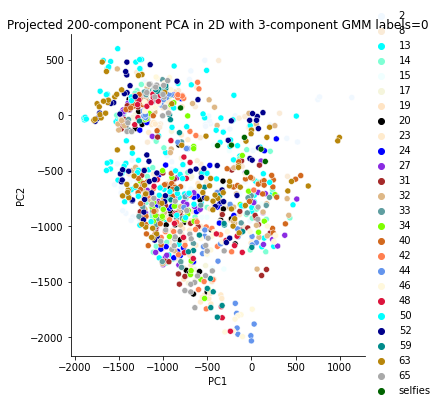

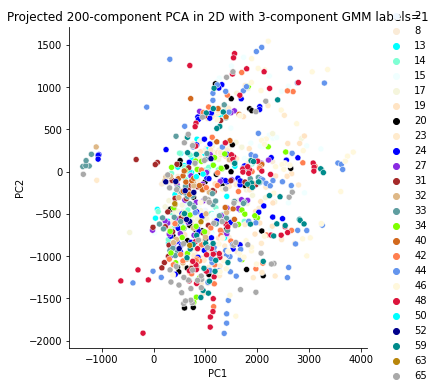

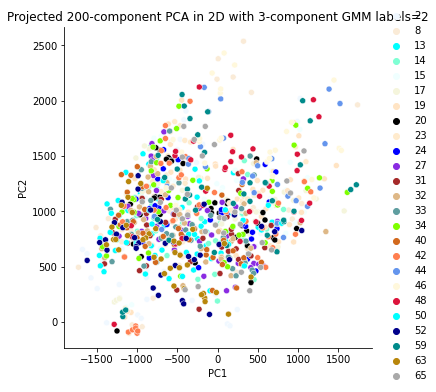

In [36]:
# visualize the images that are assigned to the same component
for label in range(0,3):
    _train_labels = [train_labels[i] for i in range(0, len(gmm_pred_labels)) if gmm_pred_labels[i]==label]
    plot_2d_or_3d(x_pca_nd[gmm_pred_labels==label,:2], _train_labels, 
                  title_name='Projected {}-component PCA in 2D with {}-component GMM labels={}'.format(n_pc, 3, label), 
                  save_name='{}C_PCA_2D_{}GMM_Y{}.png'.format(n_pc, 3, label), 
                  x_label='PC1', y_label='PC2')

### 04. Support Vector Machine (SVM)
Use the raw face images (vectorized) and the face vectors after PCA pre-processing (with dimensionality
of 80 and 200) as inputs to linear SVM. <br>Try values of the penalty parameter C. 
<br> Report the classification accuracy with different parameters and
dimensions. Discuss the effect of data dimension and parameter C on the final classification
accuracy.

In [37]:
from libsvm.svmutil import svm_train, svm_predict

##### Using raw face images

In [38]:
# format labels into numeric values (& storing conversion dictionary)
def convert_str_to_num(str_list, str_to_num=None):
    unique = list(set(str_list))
    if str_to_num is None:
        str_to_num = {string:idx for idx, string in enumerate(unique)}
    else:
        missing = [i for i in unique if i not in str_to_num.keys()]
        max_idx = max(str_to_num.values())
        for string in missing:
            str_to_num[string]=max_idx
            max_idx=+1
        
    num_list = [str_to_num[string] for string in str_list]
    return num_list, str_to_num

train_labels_num, train_str_to_num = convert_str_to_num(train_labels)
test_labels_num, str_to_num = convert_str_to_num(test_labels, train_str_to_num)

In [39]:
# if false means we have unseen labels in test set, which might be problematic
assert train_str_to_num == str_to_num

In [40]:
# documentation: https://www.csie.ntu.edu.tw/~cjlin/libsvm/
# https://projets-lium.univ-lemans.fr/sidekit/api/libsvm/libsvm_core.html
# train | 0 – linear: u’*v
linear_svm = svm_train(train_labels_num, np.asmatrix(train_data), '-t 0 -c 1e-2')

In [41]:
# predict
p_label, p_acc, p_val = svm_predict(test_labels_num, np.asmatrix(test_data), linear_svm)

Accuracy = 98.5133% (1259/1278) (classification)


In [42]:
# create custom function
def perform_clf_plus_svm(classifier, train_data, train_labels, test_data, test_labels, clf_name='Classifier', n_pc=3, svm_settings='-t 0 -c 1e-2',cut_off=None):
    if classifier is None:
        # format train and test data into np matrix
        train_x_clf_nd = np.asmatrix(train_data)
        test_x_clf_nd = np.asmatrix(test_data)
        n_pc = train_x_clf_nd.shape[1]
    else:
        # reduce dimensionality of vectorized images to n_pc
        clf = classifier(n_components=n_pc)
        if clf_name=='LDA':
            clf.fit(np.asmatrix(train_data), train_labels)
        else:
            clf.fit(np.asmatrix(train_data))

        # project train and test data into n_pc-d
        train_x_clf_nd = clf.transform(np.asmatrix(train_data))
        test_x_clf_nd = clf.transform(np.asmatrix(test_data))

    # perform classification
    svm_model = svm_train(train_labels, train_x_clf_nd, svm_settings)
    test_pred, p_acc, p_val = svm_predict(test_labels, test_x_clf_nd, svm_model)
    
    # calculate accuracy
    print('Accuracy of SVM with {}-components {} for ALL test set: {}%'.format(
        n_pc, clf_name, round(p_acc[0],3)))
    
    if cut_off is not None:
        print('Accuracy of SVM with {}-components {} for PIE test set: {}%'.format(
            n_pc, clf_name, round(calculate_accuracy(test_pred[0:cut_off-1], test_labels[0:cut_off-1])*100,3)))
        print('Accuracy of SVM with {}-components {} for selfies test set: {}%'.format(
            n_pc, clf_name, round(calculate_accuracy(test_pred[cut_off:], test_labels[cut_off:])*100,3)))
    
    #return test_pred

In [43]:
perform_clf_plus_svm(None, train_data, train_labels_num, test_data, test_labels_num, clf_name='None', n_pc=None, svm_settings='-t 0 -c 1', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=80, svm_settings='-t 0 -c 1', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=200, svm_settings='-t 0 -c 1', cut_off=len(pie_test_list))

Accuracy = 98.5133% (1259/1278) (classification)
Accuracy of SVM with 1024-components None for ALL test set: 98.513%
Accuracy of SVM with 1024-components None for PIE test set: 98.587%
Accuracy of SVM with 1024-components None for selfies test set: 66.667%
Accuracy = 98.5915% (1260/1278) (classification)
Accuracy of SVM with 80-components PCA for ALL test set: 98.592%
Accuracy of SVM with 80-components PCA for PIE test set: 98.666%
Accuracy of SVM with 80-components PCA for selfies test set: 66.667%
Accuracy = 98.4351% (1258/1278) (classification)
Accuracy of SVM with 200-components PCA for ALL test set: 98.435%
Accuracy of SVM with 200-components PCA for PIE test set: 98.509%
Accuracy of SVM with 200-components PCA for selfies test set: 66.667%


In [44]:
perform_clf_plus_svm(None, train_data, train_labels_num, test_data, test_labels_num, clf_name='None', n_pc=None, svm_settings='-t 0 -c 1e-1', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=80, svm_settings='-t 0 -c 1e-1', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=200, svm_settings='-t 0 -c 1e-1', cut_off=len(pie_test_list))


Accuracy = 98.5133% (1259/1278) (classification)
Accuracy of SVM with 1024-components None for ALL test set: 98.513%
Accuracy of SVM with 1024-components None for PIE test set: 98.587%
Accuracy of SVM with 1024-components None for selfies test set: 66.667%
Accuracy = 98.4351% (1258/1278) (classification)
Accuracy of SVM with 80-components PCA for ALL test set: 98.435%
Accuracy of SVM with 80-components PCA for PIE test set: 98.509%
Accuracy of SVM with 80-components PCA for selfies test set: 66.667%
Accuracy = 98.5133% (1259/1278) (classification)
Accuracy of SVM with 200-components PCA for ALL test set: 98.513%
Accuracy of SVM with 200-components PCA for PIE test set: 98.587%
Accuracy of SVM with 200-components PCA for selfies test set: 66.667%


In [45]:
perform_clf_plus_svm(None, train_data, train_labels_num, test_data, test_labels_num, clf_name='None', n_pc=None, svm_settings='-t 0 -c 1e-2', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=80, svm_settings='-t 0 -c 1e-2', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=200, svm_settings='-t 0 -c 1e-2', cut_off=len(pie_test_list))

Accuracy = 98.5133% (1259/1278) (classification)
Accuracy of SVM with 1024-components None for ALL test set: 98.513%
Accuracy of SVM with 1024-components None for PIE test set: 98.587%
Accuracy of SVM with 1024-components None for selfies test set: 66.667%
Accuracy = 98.5133% (1259/1278) (classification)
Accuracy of SVM with 80-components PCA for ALL test set: 98.513%
Accuracy of SVM with 80-components PCA for PIE test set: 98.587%
Accuracy of SVM with 80-components PCA for selfies test set: 66.667%
Accuracy = 98.2786% (1256/1278) (classification)
Accuracy of SVM with 200-components PCA for ALL test set: 98.279%
Accuracy of SVM with 200-components PCA for PIE test set: 98.352%
Accuracy of SVM with 200-components PCA for selfies test set: 66.667%


In [46]:
perform_clf_plus_svm(None, train_data, train_labels_num, test_data, test_labels_num, clf_name='None', n_pc=None, svm_settings='-t 0 -c 1e-3', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=80, svm_settings='-t 0 -c 1e-3', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=200, svm_settings='-t 0 -c 1e-3', cut_off=len(pie_test_list))

Accuracy = 98.5133% (1259/1278) (classification)
Accuracy of SVM with 1024-components None for ALL test set: 98.513%
Accuracy of SVM with 1024-components None for PIE test set: 98.587%
Accuracy of SVM with 1024-components None for selfies test set: 66.667%
Accuracy = 98.5915% (1260/1278) (classification)
Accuracy of SVM with 80-components PCA for ALL test set: 98.592%
Accuracy of SVM with 80-components PCA for PIE test set: 98.666%
Accuracy of SVM with 80-components PCA for selfies test set: 66.667%
Accuracy = 98.3568% (1257/1278) (classification)
Accuracy of SVM with 200-components PCA for ALL test set: 98.357%
Accuracy of SVM with 200-components PCA for PIE test set: 98.43%
Accuracy of SVM with 200-components PCA for selfies test set: 66.667%


In [47]:
# 1 – polynomial: (gamma*u’*v + coef0)^degree
perform_clf_plus_svm(None, train_data, train_labels_num, test_data, test_labels_num, clf_name='None', n_pc=None, svm_settings='-t 1 -c 1e-2', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=80, svm_settings='-t 1 -c 1e-2', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=200, svm_settings='-t 1 -c 1e-2', cut_off=len(pie_test_list))

Accuracy = 96.3224% (1231/1278) (classification)
Accuracy of SVM with 1024-components None for ALL test set: 96.322%
Accuracy of SVM with 1024-components None for PIE test set: 96.389%
Accuracy of SVM with 1024-components None for selfies test set: 66.667%
Accuracy = 96.6354% (1235/1278) (classification)
Accuracy of SVM with 80-components PCA for ALL test set: 96.635%
Accuracy of SVM with 80-components PCA for PIE test set: 96.703%
Accuracy of SVM with 80-components PCA for selfies test set: 66.667%
Accuracy = 96.9484% (1239/1278) (classification)
Accuracy of SVM with 200-components PCA for ALL test set: 96.948%
Accuracy of SVM with 200-components PCA for PIE test set: 97.017%
Accuracy of SVM with 200-components PCA for selfies test set: 66.667%


In [48]:
perform_clf_plus_svm(None, train_data, train_labels_num, test_data, test_labels_num, clf_name='None', n_pc=None, svm_settings='-t 1 -c 1e-1', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=80, svm_settings='-t 1 -c 1e-1', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=200, svm_settings='-t 1 -c 1e-1', cut_off=len(pie_test_list))

Accuracy = 96.3224% (1231/1278) (classification)
Accuracy of SVM with 1024-components None for ALL test set: 96.322%
Accuracy of SVM with 1024-components None for PIE test set: 96.389%
Accuracy of SVM with 1024-components None for selfies test set: 66.667%
Accuracy = 96.5571% (1234/1278) (classification)
Accuracy of SVM with 80-components PCA for ALL test set: 96.557%
Accuracy of SVM with 80-components PCA for PIE test set: 96.625%
Accuracy of SVM with 80-components PCA for selfies test set: 66.667%
Accuracy = 96.9484% (1239/1278) (classification)
Accuracy of SVM with 200-components PCA for ALL test set: 96.948%
Accuracy of SVM with 200-components PCA for PIE test set: 97.017%
Accuracy of SVM with 200-components PCA for selfies test set: 66.667%


In [49]:
# 2 – radial basis function: exp(-gamma*|u-v|^2)
perform_clf_plus_svm(None, train_data, train_labels_num, test_data, test_labels_num, clf_name='None', n_pc=None, svm_settings='-t 2 -c 1e-2', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=80, svm_settings='-t 2 -c 1e-2', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=200, svm_settings='-t 2 -c 1e-2', cut_off=len(pie_test_list))

Accuracy = 3.12989% (40/1278) (classification)
Accuracy of SVM with 1024-components None for ALL test set: 3.13%
Accuracy of SVM with 1024-components None for PIE test set: 3.14%
Accuracy of SVM with 1024-components None for selfies test set: 0.0%
Accuracy = 3.12989% (40/1278) (classification)
Accuracy of SVM with 80-components PCA for ALL test set: 3.13%
Accuracy of SVM with 80-components PCA for PIE test set: 3.14%
Accuracy of SVM with 80-components PCA for selfies test set: 0.0%
Accuracy = 3.12989% (40/1278) (classification)
Accuracy of SVM with 200-components PCA for ALL test set: 3.13%
Accuracy of SVM with 200-components PCA for PIE test set: 3.14%
Accuracy of SVM with 200-components PCA for selfies test set: 0.0%


In [50]:
# 3 – sigmoid: tanh(gamma*u’*v + coef0)
perform_clf_plus_svm(None, train_data, train_labels_num, test_data, test_labels_num, clf_name='None', n_pc=None, svm_settings='-t 3 -c 1e-2', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=80, svm_settings='-t 3 -c 1e-2', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=200, svm_settings='-t 3 -c 1e-2', cut_off=len(pie_test_list))

Accuracy = 3.12989% (40/1278) (classification)
Accuracy of SVM with 1024-components None for ALL test set: 3.13%
Accuracy of SVM with 1024-components None for PIE test set: 3.14%
Accuracy of SVM with 1024-components None for selfies test set: 0.0%
Accuracy = 5.55556% (71/1278) (classification)
Accuracy of SVM with 80-components PCA for ALL test set: 5.556%
Accuracy of SVM with 80-components PCA for PIE test set: 5.573%
Accuracy of SVM with 80-components PCA for selfies test set: 0.0%
Accuracy = 5.55556% (71/1278) (classification)
Accuracy of SVM with 200-components PCA for ALL test set: 5.556%
Accuracy of SVM with 200-components PCA for PIE test set: 5.573%
Accuracy of SVM with 200-components PCA for selfies test set: 0.0%


In [51]:
# significantly reduce PC
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=50, svm_settings='-t 0 -c 1e-2', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=30, svm_settings='-t 0 -c 1e-2', cut_off=len(pie_test_list))
perform_clf_plus_svm(PCA, train_data, train_labels_num, test_data, test_labels_num, clf_name='PCA', n_pc=10, svm_settings='-t 0 -c 1e-2', cut_off=len(pie_test_list))

Accuracy = 97.7308% (1249/1278) (classification)
Accuracy of SVM with 50-components PCA for ALL test set: 97.731%
Accuracy of SVM with 50-components PCA for PIE test set: 97.802%
Accuracy of SVM with 50-components PCA for selfies test set: 66.667%
Accuracy = 97.0266% (1240/1278) (classification)
Accuracy of SVM with 30-components PCA for ALL test set: 97.027%
Accuracy of SVM with 30-components PCA for PIE test set: 97.096%
Accuracy of SVM with 30-components PCA for selfies test set: 66.667%
Accuracy = 74.8044% (956/1278) (classification)
Accuracy of SVM with 10-components PCA for ALL test set: 74.804%
Accuracy of SVM with 10-components PCA for PIE test set: 74.804%
Accuracy of SVM with 10-components PCA for selfies test set: 66.667%


In [52]:
# Use alternate package to CHECK
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1e-2)
model.fit(train_data, train_labels_num)
test_fit = model.predict(test_data)
calculate_accuracy(test_fit, test_labels_num)

0.9843505477308294

In [53]:
model = SVC(kernel='linear', C=1e-1)
model.fit(train_data, train_labels_num)
test_fit = model.predict(test_data)
calculate_accuracy(test_fit, test_labels_num)

0.9843505477308294